# Helper Functions

In [694]:
import sys
import os

import os
cwd = os.getcwd()
root_path = os.path.abspath('..\..')
sys.path.insert(0, root_path)

print(sys.path)

['c:\\Users\\ronal\\OneDrive\\Documents\\GitHub\\BPAD', 'c:\\Users\\ronal\\OneDrive\\Documents\\GitHub\\BPAD', 'c:\\Users\\ronal\\OneDrive\\Documents\\GitHub\\BPAD', 'c:\\Users\\ronal\\OneDrive\\Documents\\GitHub\\BPAD', 'c:\\Users\\ronal\\OneDrive\\Documents\\GitHub\\BPAD', 'c:\\Users\\ronal\\OneDrive\\Documents\\GitHub\\BPAD', 'c:\\Users\\ronal\\OneDrive\\Documents\\GitHub\\BPAD', 'c:\\Users\\ronal\\OneDrive\\Documents\\GitHub\\BPAD', 'c:\\Users\\ronal\\OneDrive\\Documents\\GitHub\\BPAD', 'c:\\Users\\ronal\\OneDrive\\Documents\\GitHub\\BPAD', 'c:\\Users\\ronal\\OneDrive\\Documents\\GitHub\\BPAD', 'c:\\Users\\ronal\\OneDrive\\Documents\\GitHub\\BPAD', 'c:\\Users\\ronal\\OneDrive\\Documents\\GitHub\\BPAD', 'c:\\Users\\ronal\\OneDrive\\Documents\\GitHub\\BPAD', 'c:\\Users\\ronal\\OneDrive\\Documents\\GitHub\\BPAD', 'c:\\Users\\ronal\\OneDrive\\Documents\\GitHub\\BPAD', 'c:\\Users\\ronal\\OneDrive\\Documents\\GitHub\\BPAD', 'c:\\Users\\ronal\\OneDrive\\Documents\\GitHub\\BPAD', 'c:\\User

In [695]:
import re
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from utils.fs import RESULTS_RAW_DIR

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from utils.enums import Perspective

In [696]:
import os

def list_subfolders(experiment_name):
    experiment_path = os.path.join(RESULTS_RAW_DIR, experiment_name)
    # Get all subfolder names in the specified directory
    run_names = [name for name in os.listdir(experiment_path) if os.path.isdir(os.path.join(experiment_path, name))]
    return run_names

In [697]:
import json

def load_results(run_name, verbose=False,directory=None):
    if directory:
        run_path = os.path.join(RESULTS_RAW_DIR, directory, run_name)
    else:
        run_path = os.path.join(RESULTS_RAW_DIR, run_name)
    npy_files = [file for file in os.listdir(run_path) if file.endswith('.npy')]

    loaded_data = {}

    # Load each .npy file and use the file name (without extension) as the key
    for npy_file in npy_files:
        file_path = os.path.join(run_path, npy_file)
        key = os.path.splitext(npy_file)[0]  # Get the file name without .npy extension
        loaded_data[key] = np.load(file_path)

        if verbose: print(f"{loaded_data[key].shape} \t {key}")

    return loaded_data

def load_config(run_name, directory=None):
    if directory:
        config_path = os.path.join(RESULTS_RAW_DIR, directory, run_name, "config.json")
    else:
        config_path = os.path.join(RESULTS_RAW_DIR, run_name, "config.json")

    with open(config_path, "r") as f:
        config = json.load(f)
    return config

def get_buckets(keys):
    buckets = set()
    for key in keys:
        numbers = re.findall(r'\d+', key)
        buckets.update(map(int, numbers))
    if len(buckets) > 0:
        return sorted(buckets)
    return None

In [698]:
def plot_losses(results, labels, directory, run_name, perspective, level, bucket=None, zoom=[[11000,13000],[-0.05, 0.2]], show_plots=True):
    def scatter_plot(ax, results, labels):
        y_values = results
        x_values = np.arange(len(results))
        ax.scatter(x_values[labels == 0], y_values[labels == 0], c='grey', s=3, label='Normal Prefixes', zorder=1)
        ax.scatter(x_values[labels == 1], y_values[labels == 1], c='red', s=3, label='Anomalous Prefixes', zorder=2)
        ax.grid(True)

    # Normalize results
    results = np.interp(results, (results.min(), results.max()), (0, 1))

    subtitle = f'{directory}     {run_name}'
    if len(results) == 0:
        print(f'ERROR no results found for {subtitle}')
    else:
        fig, ax = plt.subplots(figsize=(15, 6))

        labels = labels[:, perspective]
        scatter_plot(ax, results, labels)
        
        perspective_name = Perspective.values()[perspective]

        bucket_string = ''
        if bucket is not None:
            bucket_string = f'with bucket size {str(bucket)}'
        
        title = f'Error per Prefix on the {perspective_name} perspective at {level} level {bucket_string}'
        
        # Print to keep track of plotting
        # print(f'\t {title}')
        
        plt.title(f'{title}\n{subtitle}')
        plt.xlabel('Prefix Index')
        plt.ylabel('Loss')
        
        if zoom:
            axins = inset_axes(ax, width="60%", height="60%", loc='upper right')

            scatter_plot(axins, results, labels)
            axins.set_xlim(zoom[0])
            axins.set_ylim(zoom[1])
            _,_ = ax.indicate_inset_zoom(axins, edgecolor="black", linewidth=3)

        plt.xlabel('Case Index')
        plt.ylabel('Error')
        plt.legend(loc='upper right')
        
        plot_path = f"plots\{directory}\{run_name} "
        os.makedirs(plot_path, exist_ok=True)
        plt.savefig(f"{plot_path}\{perspective_name}_{level}_{bucket_string}.png", format='png', dpi=300)
        
        if show_plots:
            plt.show()
        plt.close()

def bucket_plot_losses(results_name, labels_name, run_name, directory, bucket_lengths, results, perspective, level, zoom=[[11000,13000],[-0.05, 0.2]], show_plots=True, pbar=None):
    if bucket_lengths is None:
        plot_losses(
            results=results[f'{results_name}'], 
            labels=results[f'{labels_name}'],
            directory=directory,
            run_name=run_name, perspective=perspective, level=level, bucket=None, zoom=zoom, show_plots=show_plots)
        if pbar:
            pbar.update(1)       
    else:
        for bucket in bucket_lengths:
            plot_losses(
                results=results[f'{results_name}_{bucket}'], 
                labels=results[f'{labels_name}_{bucket}'],
                directory=directory,
                run_name=run_name, perspective=perspective, level=level, bucket=bucket, zoom=zoom, show_plots=show_plots)
            if pbar:
                pbar.update(1)  


# Loading Runs

In [699]:
directories = [
    'Experiment_Finetuning_Fixed_Vector_Vector_Sizes',
    # 'Experiment_Anomaly_Percentage_v2',
    # 'Experiment_Synthetic_Dataset_v4',
    # 'Experiment_Prefix',
    # 'Experiment_Batch_Size',
    ] 
directory = directories[-1]
print(directory)

score_results = True
score_summary = True
plot_results = False
filter_beginning_percentage = 20

Experiment_Finetuning_Fixed_Vector_Vector_Sizes


In [700]:
run_list = list_subfolders(directory)
print(run_list)

# run_list = [run_list[0]]
# print(run_list)

['24-11-21-18-03_DAE_EncodingCategorical.FIXED_VECTOR_EncodingNumerical.MIN_MAX_SCALING', '24-11-21-18-04_DAE_EncodingCategorical.FIXED_VECTOR_EncodingNumerical.MIN_MAX_SCALING', '24-11-21-18-05_DAE_EncodingCategorical.FIXED_VECTOR_EncodingNumerical.MIN_MAX_SCALING', '24-11-21-18-06_DAE_EncodingCategorical.FIXED_VECTOR_EncodingNumerical.MIN_MAX_SCALING', '24-11-21-18-08_DAE_EncodingCategorical.FIXED_VECTOR_EncodingNumerical.MIN_MAX_SCALING', '24-11-21-18-09_DAE_EncodingCategorical.FIXED_VECTOR_EncodingNumerical.MIN_MAX_SCALING', '24-11-21-18-11_DAE_EncodingCategorical.FIXED_VECTOR_EncodingNumerical.MIN_MAX_SCALING', '24-11-21-18-12_DAE_EncodingCategorical.FIXED_VECTOR_EncodingNumerical.MIN_MAX_SCALING', '24-11-21-18-13_DAE_EncodingCategorical.FIXED_VECTOR_EncodingNumerical.MIN_MAX_SCALING', '24-11-21-18-14_DAE_EncodingCategorical.FIXED_VECTOR_EncodingNumerical.MIN_MAX_SCALING', '24-11-21-18-16_DAE_EncodingCategorical.FIXED_VECTOR_EncodingNumerical.MIN_MAX_SCALING', '24-11-21-18-17_DAE_

In [701]:
run_list[0]

'24-11-21-18-03_DAE_EncodingCategorical.FIXED_VECTOR_EncodingNumerical.MIN_MAX_SCALING'

In [702]:
runs = []
for run_name in run_list:
    try:
        results = load_results(run_name=run_name, directory=directory)
        config = load_config(run_name=run_name, directory=directory)
        buckets = get_buckets(results.keys())
        timestamp = run_name.split('_')[0]

        if filter_beginning_percentage is not None:
            for key, value in results.items():
                filter_index = int(value.shape[0] / 10)
                results[key] = value[filter_index:]

        runs.append({
            "name": run_name,
            "timestamp": timestamp,
            "results": results,
            "config": config,
            "buckets": buckets
        })
    except:
        continue

# Plot Results

In [703]:
results_config = [
    ('result_DAE_trace_Order', 'labels_DAE_trace', Perspective.ORDER, 'trace'),
    ('result_DAE_trace_Attribute', 'labels_DAE_trace', Perspective.ATTRIBUTE, 'trace'),
    ('result_DAE_trace_Arrival Time', 'labels_DAE_trace', Perspective.ARRIVAL_TIME, 'trace'),
    ('result_DAE_trace_Workload', 'labels_DAE_trace', Perspective.WORKLOAD, 'trace'),
]

In [704]:
if plot_results:
    show_plots = False

    nr_buckets = 0
    for run in runs:
        nr_buckets += len(run["buckets"])

    total_iterations = nr_buckets * len(results_config)
    with tqdm(total=total_iterations, desc="Generating Plots") as pbar:
        for run in runs:
            # print(f"Generating: {directory}\t{run_name}")
            for config in results_config:
                # try:
                bucket_plot_losses(
                    results_name=config[0], 
                    labels_name=config[1],
                    directory=directory,
                    run_name=run["name"],
                    bucket_lengths=run["buckets"],
                    results=run["results"],
                    perspective=config[2],
                    level=config[3],
                    zoom=None,
                    show_plots=show_plots,
                    pbar=pbar)
                # except:
                #     print("Error loading ")


# Score Results

In [705]:
def get_indexes_by_value(arr):
    value_to_indexes = {}
    for index, value in enumerate(arr):
        if value not in value_to_indexes:
            value_to_indexes[value] = []
        value_to_indexes[value].append(index)
    return value_to_indexes

def normalize(array):
    array = np.array(array)
    return np.interp(array, (array.min(), array.max()), (0, 1))

# Function to extract the number after the last underscore
def extract_number(key):
    return int(key.split('_')[-1])

In [706]:
def process_attribute_labels(output, values, case_length, perspective, perspective_label_indices):
    # print(values.shape)

    perspective_value = values[perspective, :, :, :]
    # print(perspective_value.shape)

    perspective_masked = perspective_value[:, :case_length, :]
    # print(perspective_masked.shape)

    perspective_indexed = perspective_masked[:,:,perspective_label_indices[perspective]]
    # print(perspective_indexed.shape)

    perspective_attribute_value = perspective_indexed.reshape(-1) # Flatten the output
    # print(perspective_attribute_value.shape)

    output.append(perspective_attribute_value)

In [707]:
def reshape_data_for_scoring(results, perspective_label_indices):
    labels_DAE_attribute_Arrival_Time = []
    labels_DAE_attribute_Workload = []
    labels_DAE_attribute_Order = []
    labels_DAE_attribute_Attribute  = []

    labels_DAE_event = []
    labels_DAE_trace = []

    result_DAE_attribute_Arrival_Time = []
    result_DAE_event_Arrival_Time = []
    result_DAE_trace_Arrival_Time = []
    result_DAE_attribute_Workload = []
    result_DAE_event_Workload = []
    result_DAE_trace_Workload = []
    result_DAE_attribute_Order = []
    result_DAE_event_Order = []
    result_DAE_trace_Order = []
    result_DAE_attribute_Attribute = []
    result_DAE_event_Attribute = []
    result_DAE_trace_Attribute = []

    for (key, value) in results.items():
        # print(key, value.shape)

        length = int(key.split('_')[-1])
        perspective = key.split('_')[-2]
        if 'losses' in key:
            continue
        elif 'labels' in key:
            if 'attribute' in key:
                transposed_value = np.transpose(value, (3,0,1,2))# [:, :, :length, :]

                process_attribute_labels(
                    output=labels_DAE_attribute_Arrival_Time,
                    values=transposed_value, 
                    case_length=length, 
                    perspective=Perspective.ARRIVAL_TIME,
                    perspective_label_indices=perspective_label_indices)
                process_attribute_labels(
                    output=labels_DAE_attribute_Attribute,
                    values=transposed_value, 
                    case_length=length, 
                    perspective=Perspective.ATTRIBUTE,
                    perspective_label_indices=perspective_label_indices)
                process_attribute_labels(
                    output=labels_DAE_attribute_Order,
                    values=transposed_value, 
                    case_length=length, 
                    perspective=Perspective.ORDER,
                    perspective_label_indices=perspective_label_indices)
                process_attribute_labels(
                    output=labels_DAE_attribute_Workload,
                    values=transposed_value, 
                    case_length=length, 
                    perspective=Perspective.WORKLOAD,
                    perspective_label_indices=perspective_label_indices)

                # # print(perspective_value.shape)
                # perspective_value = perspective_value.reshape(perspective_value.shape[0], -1)
                # # print(perspective_value.shape)
                # labels_DAE_attribute.append(perspective_value)
            elif 'event' in key:
                perspective_value = np.transpose(value, (2,0,1))[:, :, :length]
                perspective_value = perspective_value.reshape(perspective_value.shape[0], -1)
                labels_DAE_event.append(perspective_value)
            elif 'trace' in key:
                perspective_value = np.transpose(value, (1,0))
                # print(perspective_value.shape)
                labels_DAE_trace.append(perspective_value)
        elif 'result' in key:
            if 'attribute' in key:
                # print(value.shape)
                # value_max = np.max(value, axis=2)
                # print(value.shape, normalize(value.reshape(-1)).shape, perspective)
                # print(value.shape)
                value = normalize(value.reshape(-1))
                # print(value.shape)
                if 'Arrival Time' in perspective:
                    result_DAE_attribute_Arrival_Time.append(value)
                elif 'Order' in perspective:
                    result_DAE_attribute_Order.append(value)
                elif 'Workload' in perspective:
                    result_DAE_attribute_Workload.append(value)
                elif 'Attribute' in perspective:
                    result_DAE_attribute_Attribute.append(value)
            if 'event' in key:
                value = normalize(value.reshape(-1))
                if 'Arrival Time' in perspective:
                    result_DAE_event_Arrival_Time.append(value)
                elif 'Order' in perspective:
                    result_DAE_event_Order.append(value)
                elif 'Workload' in perspective:
                    result_DAE_event_Workload.append(value)
                elif 'Attribute' in perspective:
                    result_DAE_event_Attribute.append(value)
            elif 'trace' in key:
                value = normalize(value)
                if 'Arrival Time' in perspective:
                    result_DAE_trace_Arrival_Time.append(value)
                elif 'Order' in perspective:
                    result_DAE_trace_Order.append(value)
                elif 'Workload' in perspective:
                    result_DAE_trace_Workload.append(value)
                elif 'Attribute' in perspective:
                    result_DAE_trace_Attribute.append(value)


    # labels_DAE_attribute = np.concatenate(labels_DAE_attribute, axis=1)
    labels_DAE_event = np.concatenate(labels_DAE_event, axis=1)    
    labels_DAE_trace = np.concatenate(labels_DAE_trace, axis=1)

    # print(labels_DAE_attribute.shape)

    # print(np.concatenate(result_DAE_event_Order, axis=0).shape)
    # print(result_DAE_attribute_Attribute.shape)
    # print(result_DAE_attribute_Arrival_Time.shape)
    # print(result_DAE_attribute_Workload.shape)

    labels_DAE_attribute = [
        np.concatenate(labels_DAE_attribute_Order, axis=0),
        np.concatenate(labels_DAE_attribute_Attribute, axis=0),
        np.concatenate(labels_DAE_attribute_Arrival_Time, axis=0),
        np.concatenate(labels_DAE_attribute_Workload, axis=0)
    ]

    result_DAE_attribute = [
        np.concatenate(result_DAE_attribute_Order, axis=0),
        np.concatenate(result_DAE_attribute_Attribute, axis=0),
        np.concatenate(result_DAE_attribute_Arrival_Time, axis=0),
        np.concatenate(result_DAE_attribute_Workload, axis=0)
    ]

    result_DAE_event = [
        np.concatenate(result_DAE_event_Order, axis=0),
        np.concatenate(result_DAE_event_Attribute, axis=0),
        np.concatenate(result_DAE_event_Arrival_Time, axis=0),
        np.concatenate(result_DAE_event_Workload, axis=0)
    ]

    result_DAE_trace = [
        np.concatenate(result_DAE_trace_Order, axis=0),
        np.concatenate(result_DAE_trace_Attribute, axis=0),
        np.concatenate(result_DAE_trace_Arrival_Time, axis=0),
        np.concatenate(result_DAE_trace_Workload, axis=0)
    ]

    return labels_DAE_attribute, labels_DAE_event, labels_DAE_trace, result_DAE_attribute, result_DAE_event, result_DAE_trace

In [708]:
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve

def calculate_f1(precision, recall):
    # Check if both precision and recall are zero to avoid division by zero
    precision[precision == 0] = 1e-6
    recall[recall == 0] = 1e-6

    if np.any(precision != 0) and np.any(recall != 0):
        return (2 * precision * recall) / (precision + recall)
    else:
        return 0

def calculate_scores(y_trues, pred_probs, perspective):
    y_true = y_trues[perspective][:]
    pred_prob = pred_probs[perspective][:]

    # ROC-AUC
    roc_auc = roc_auc_score(y_true, pred_prob)

    # PR-AUC
    pr_auc = average_precision_score(y_true, pred_prob)

    # F1-Score
    precision, recall, thresholds = precision_recall_curve(y_true=y_true, probas_pred=pred_prob)
    # print(precision.shape)
    # print(recall.shape)
    f1s=calculate_f1(precision,recall)
    f1s[np.isnan(f1s)] = 0
    # print(f1s)
    f1_best_index=np.argmax(f1s)
    # recall_best_index=np.mean(recall)
    # precision_best_index=np.mean(precision)

    return roc_auc, pr_auc, f1s[f1_best_index], np.mean(precision), np.mean(recall)

In [709]:
import itertools
import pandas as pd

def score(run):
    results = run['results']
    config = run['config']
    timestamp = run['timestamp']

    sorted_results = dict(sorted(results.items(), key=lambda x: extract_number(x[0])))
    perspective_label_indices = get_indexes_by_value(config['attribute_perspectives_original'])

    (
        labels_DAE_attribute, 
        labels_DAE_event, 
        labels_DAE_trace, 
        result_DAE_attribute, 
        result_DAE_event, 
        result_DAE_trace
    ) = reshape_data_for_scoring(results=sorted_results, perspective_label_indices=perspective_label_indices)

    level = ['trace', 'event', 'attribute']
    datasets = [labels_DAE_trace, labels_DAE_event, labels_DAE_attribute]
    results = [result_DAE_trace, result_DAE_event, result_DAE_attribute]
    perspectives = Perspective.keys()

    scores = []
    for (level, dataset, result), perspective in itertools.product(zip(level, datasets, results), perspectives):
        try:
            roc_auc, pr_auc, f1, precision, recall = calculate_scores(dataset, result, perspective)
            # print(level, perspective, roc_auc, pr_auc)

            scores.append({
                # High level differentiatiors
                'run_name':config['run_name'],
                'model':config['model'],
                'dataset':config['dataset'],
                'timestamp':timestamp,
                # 'repeat':config['repeat'],
                # Level/Perspectives
                'level': level,
                'perspective': Perspective.values()[perspective],
                # Scores
                'roc_auc': roc_auc,
                'pr_auc': pr_auc,
                'f1': f1,
                'precision':precision,
                'recall':recall,
                'run_time': config['run_time'],
                # Config
                'batch_size':config['batch_size'],
                'prefix':config['prefix'],
                'buckets':config['bucket_boundaries'],
                'categorical_encoding':config['categorical_encoding'],
                'numerical_encoding':config['numerical_encoding'],
                'vector_size':config['vector_size'],
                'window_size':config['window_size'] 
            })
        except:
            print(level, perspective)

    return pd.DataFrame(scores)

In [710]:
scores_dfs = []
if score_results:
    for run in tqdm(runs):
        scores_df = score(run=run)
        scores_dfs.append(scores_df)

    all_scores_df = pd.concat(scores_dfs, ignore_index=True)

100%|██████████| 15/15 [00:19<00:00,  1.32s/it]


In [711]:
all_scores_df.head(5)

,run_name,model,dataset,timestamp,level,perspective,roc_auc,pr_auc,f1,precision,recall,run_time,batch_size,prefix,buckets,categorical_encoding,numerical_encoding,vector_size,window_size
0,Experiment_Finetuning_Fixed_Vector_Vector_Sizes,DAE,process_log_24-11-21-11-44_gigantic_0.45_4_1.j...,24-11-21-18-03,trace,Order,0.598381,0.217045,0.357585,0.214500,0.572609,65.048221,8,True,"[3, 4, 5, 6, 7, 8, 9, 16]",Fixed Vector,Min Max Scaling,10,0
1,Experiment_Finetuning_Fixed_Vector_Vector_Sizes,DAE,process_log_24-11-21-11-44_gigantic_0.45_4_1.j...,24-11-21-18-03,trace,Attribute,0.567192,0.240939,0.372645,0.239438,0.546235,65.048221,8,True,"[3, 4, 5, 6, 7, 8, 9, 16]",Fixed Vector,Min Max Scaling,10,0
2,Experiment_Finetuning_Fixed_Vector_Vector_Sizes,DAE,process_log_24-11-21-11-44_gigantic_0.45_4_1.j...,24-11-21-18-03,trace,Arrival Time,0.582605,0.189954,0.302384,0.187296,0.562620,65.048221,8,True,"[3, 4, 5, 6, 7, 8, 9, 16]",Fixed Vector,Min Max Scaling,10,0
3,Experiment_Finetuning_Fixed_Vector_Vector_Sizes,DAE,process_log_24-11-21-11-44_gigantic_0.45_4_1.j...,24-11-21-18-03,trace,Workload,0.592600,0.190749,0.303033,0.186477,0.571556,65.048221,8,True,"[3, 4, 5, 6, 7, 8, 9, 16]",Fixed Vector,Min Max Scaling,10,0
4,Experiment_Finetuning_Fixed_Vector_Vector_Sizes,DAE,process_log_24-11-21-11-44_gigantic_0.45_4_1.j...,24-11-21-18-03,event,Order,0.501632,0.043709,0.091087,0.043474,0.496724,65.048221,8,True,"[3, 4, 5, 6, 7, 8, 9, 16]",Fixed Vector,Min Max Scaling,10,0


In [712]:
# Generate additional rows for the encoding methods combined
group_cols = [
    "run_name", "model", "dataset", "level", "perspective", "batch_size", "vector_size"
]
averages_methods = (
    all_scores_df.groupby(group_cols)
    .agg({
        "roc_auc": "mean", 
        "pr_auc": "mean", 
        "f1": "mean", 
        "precision": "mean", 
        "recall": "mean",
        "run_time": "mean"})
    .reset_index()
)
averages_methods["categorical_encoding"] = "All"
averages_methods["timestamp"] = "Average"


result_methods_df = pd.concat([all_scores_df, averages_methods], ignore_index=True)

In [713]:
averages_methods.head(1)

,run_name,model,dataset,level,perspective,batch_size,vector_size,roc_auc,pr_auc,f1,precision,recall,run_time,categorical_encoding,timestamp
0,Experiment_Finetuning_Fixed_Vector_Vector_Sizes,DAE,process_log_24-11-21-11-44_gigantic_0.45_4_1.j...,attribute,Arrival Time,8,10,0.456139,0.030696,0.068079,0.029877,0.442488,67.930385,All,Average


In [714]:
print(all_scores_df.shape)
print(averages_methods.shape)
print(result_methods_df.shape)

(180, 19)
(60, 15)
(240, 19)


In [715]:
averages_methods.head(1)

,run_name,model,dataset,level,perspective,batch_size,vector_size,roc_auc,pr_auc,f1,precision,recall,run_time,categorical_encoding,timestamp
0,Experiment_Finetuning_Fixed_Vector_Vector_Sizes,DAE,process_log_24-11-21-11-44_gigantic_0.45_4_1.j...,attribute,Arrival Time,8,10,0.456139,0.030696,0.068079,0.029877,0.442488,67.930385,All,Average


In [716]:
# Generate additional rows for the perspectives combined
group_cols = [
    "run_name", "model", "dataset", "timestamp", "level", "categorical_encoding", "batch_size", "run_time", "vector_size"
]
averages_perspective = (
    result_methods_df.groupby(group_cols)
    .agg({"roc_auc": "mean", "pr_auc": "mean", "f1": "mean", "precision": "mean", "recall": "mean"})
    .reset_index()
)
averages_perspective["perspective"] = "All"


result_df = pd.concat([result_methods_df, averages_perspective], ignore_index=True)

In [717]:
print(all_scores_df.shape)
print(averages_perspective.shape)
print(result_df.shape)

(180, 19)
(60, 15)
(300, 19)


In [718]:
result_df.head(1)

,run_name,model,dataset,timestamp,level,perspective,roc_auc,pr_auc,f1,precision,recall,run_time,batch_size,prefix,buckets,categorical_encoding,numerical_encoding,vector_size,window_size
0,Experiment_Finetuning_Fixed_Vector_Vector_Sizes,DAE,process_log_24-11-21-11-44_gigantic_0.45_4_1.j...,24-11-21-18-03,trace,Order,0.598381,0.217045,0.357585,0.2145,0.572609,65.048221,8,True,"[3, 4, 5, 6, 7, 8, 9, 16]",Fixed Vector,Min Max Scaling,10,0.0


In [719]:
# Generate additional columns used in analysis
result_df["dataset_size"] = result_df["dataset"].str.split('_').str[3]
result_df["anomaly_percentage"] = result_df["dataset"].str.split('_').str[4]
result_df["anomaly_percentage"] = result_df["anomaly_percentage"].astype(float)
result_df["buckets"] = result_df["buckets"].astype(str)
result_df["batch_size"] = result_df["batch_size"].astype(str)
result_df["vector_size"] = result_df["vector_size"].astype(str)

In [720]:
result_df.shape

(300, 21)

In [ ]:
result_df.tail(1)

,run_name,model,dataset,timestamp,level,perspective,roc_auc,pr_auc,f1,precision,...,run_time,batch_size,prefix,buckets,categorical_encoding,numerical_encoding,vector_size,window_size,dataset_size,anomaly_percentage
295,Experiment_Finetuning_Fixed_Vector_Vector_Sizes,DAE,process_log_24-11-21-11-44_gigantic_0.45_4_1.j...,Average,trace,All,0.582569,0.208969,0.332939,0.206163,...,67.930385,8,NaN,nan,All,NaN,10,NaN,gigantic,0.45
296,Experiment_Finetuning_Fixed_Vector_Vector_Sizes,DAE,process_log_24-11-21-11-44_gigantic_0.45_4_1.j...,Average,trace,All,0.606405,0.230278,0.338746,0.223499,...,68.319006,8,NaN,nan,All,NaN,20,NaN,gigantic,0.45
297,Experiment_Finetuning_Fixed_Vector_Vector_Sizes,DAE,process_log_24-11-21-11-44_gigantic_0.45_4_1.j...,Average,trace,All,0.606404,0.229642,0.340987,0.223148,...,69.117392,8,NaN,nan,All,NaN,40,NaN,gigantic,0.45
298,Experiment_Finetuning_Fixed_Vector_Vector_Sizes,DAE,process_log_24-11-21-11-44_gigantic_0.45_4_1.j...,Average,trace,All,0.621731,0.239310,0.349219,0.230233,...,72.552941,8,NaN,nan,All,NaN,80,NaN,gigantic,0.45
299,Experiment_Finetuning_Fixed_Vector_Vector_Sizes,DAE,process_log_24-11-21-11-44_gigantic_0.45_4_1.j...,Average,trace,All,0.624077,0.243602,0.349029,0.233289,...,83.330554,8,NaN,nan,All,NaN,160,NaN,gigantic,0.45


In [722]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_single_score(data, score_type, level, ax, label_name, xlabel_name):
    subset = data[data["level"] == level]
    
    sns.lineplot(
        data=subset,
        x=label_name,
        y=score_type,
        hue="perspective",
        style="categorical_encoding",
        markers=True,
        dashes=False,
        ax=ax
    )
    
    ax.set_title(f"{score_type.capitalize()} Scores (Level={level.capitalize()})")
    ax.set_xlabel(xlabel_name)
    ax.set_ylabel(f"{score_type.capitalize()}" if level=='trace' else "")
    ax.tick_params(axis="x", rotation=45)

def plot_scores(data, directory, title, label_name, xlabel_name, summary=True):
    levels = ["trace", "event", "attribute"]
    
    # Create a figure with 3 rows and 3 columns for the PR AUC, ROC AUC and F1 plots
    if summary:
        fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=False)
    else:
        fig, axes = plt.subplots(6, 3, figsize=(18, 18), sharex=True, sharey=False)
    
    handles, labels = [], []

    for i, level in enumerate(levels):
        plot_single_score(data, "f1", level, axes[0, i], label_name, xlabel_name)
        plot_single_score(data, "run_time", level, axes[1, i], label_name, xlabel_name)
        if not summary:
            plot_single_score(data, "pr_auc", level, axes[2, i], label_name, xlabel_name)
            plot_single_score(data, "roc_auc", level, axes[3, i], label_name, xlabel_name)
            plot_single_score(data, "precision", level, axes[4, i], label_name, xlabel_name)
            plot_single_score(data, "recall", level, axes[5, i], label_name, xlabel_name)

        if not handles and not labels:  # Collect handles and labels only once
            handles, labels = axes[0, i].get_legend_handles_labels()
        
        axes[0, i].legend().remove()
        axes[1, i].legend().remove()
        if not summary:
            axes[2, i].legend().remove()
            axes[3, i].legend().remove()
            axes[4, i].legend().remove()
            axes[5, i].legend().remove()

    
    # Add a single legend for both rows
    fig.legend(
        handles,
        labels,
        title="Perspective & Encoding",
        loc="upper center",
        bbox_to_anchor=(0.5, -0.05),
        ncol=3
    )
    
    # Adjust layout to avoid overlap
    plt.tight_layout()

    plot_path = f"plots\{directory}"
    os.makedirs(plot_path, exist_ok=True)
    plt.savefig(f"{plot_path}\experimental_results_{title}.png", format='png', dpi=300)

    plt.show()

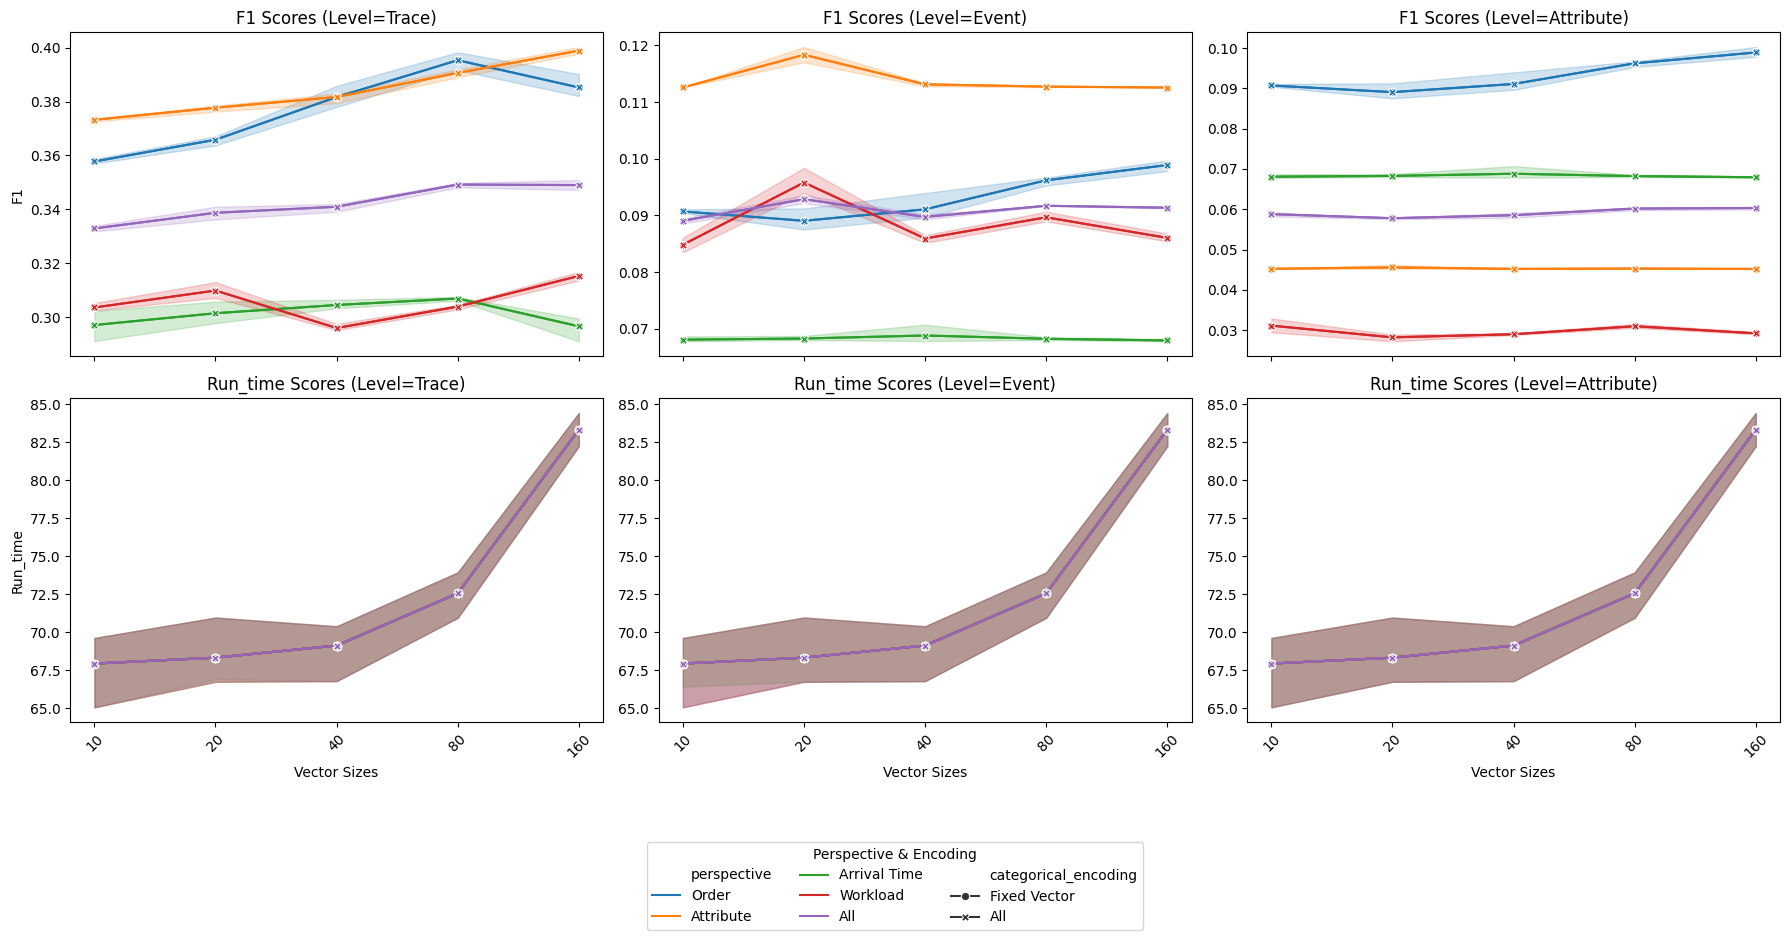

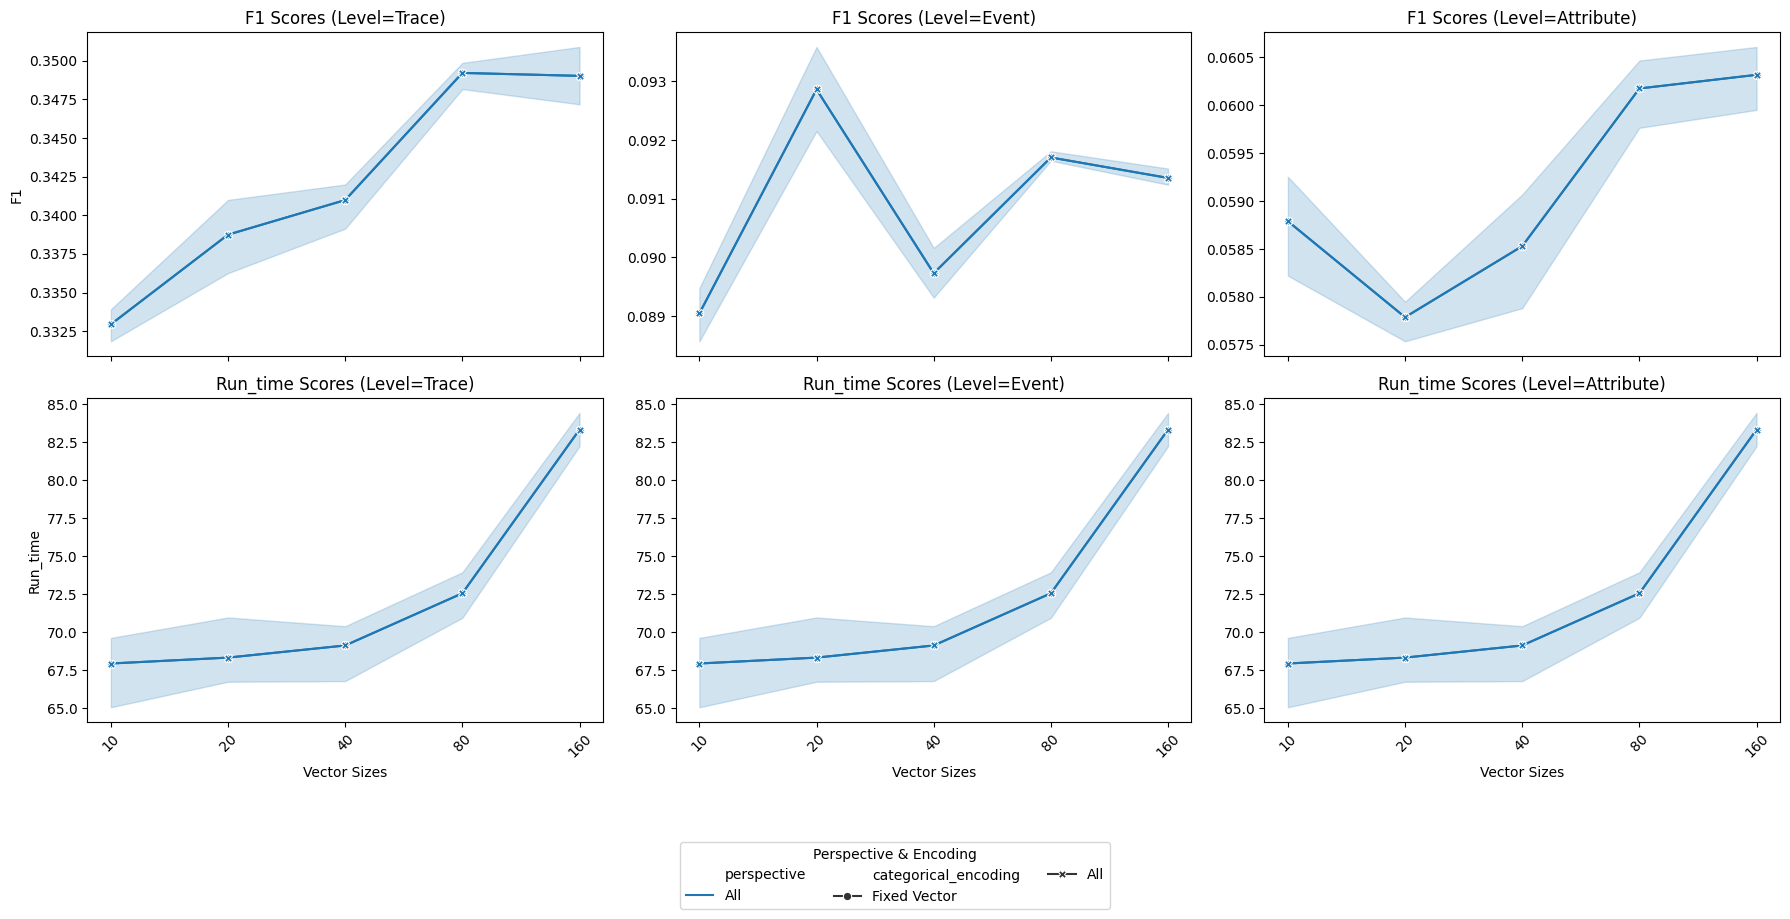

In [ ]:
if "Experiment_Anomaly_Percentage" in directory:
    xlabel_name="Anomaly Percentages"
    label_name="anomaly_percentage"
    plot_scores(result_df, directory, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name,summary=score_summary)
    plot_scores(result_df[result_df["perspective"] == "All"], directory, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name,summary=score_summary)
elif "Experiment_Synthetic_Dataset" in directory:
    xlabel_name="Dataset Sizes"
    label_name="dataset_size"
    plot_scores(result_df, directory, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name,summary=score_summary)
    plot_scores(result_df[result_df["perspective"] == "All"], directory, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name,summary=score_summary)
elif "Experiment_Batch_Size" in directory:
    xlabel_name="Batch Sizes"
    label_name="batch_size"
    plot_scores(result_df, directory, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name,summary=score_summary)
    plot_scores(result_df[result_df["perspective"] == "All"], directory, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name,summary=score_summary)
elif "Experiment_Finetuning_Fixed_Vector_Vector_Sizes":
    filtered_result_df = result_df[result_df["categorical_encoding"] == "Fixed Vector"]

    xlabel_name="Vector Sizes"
    label_name="vector_size"
    plot_scores(filtered_result_df, directory, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name,summary=score_summary)
    plot_scores(filtered_result_df[filtered_result_df["perspective"] == "All"], directory, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name,summary=score_summary)    